In [22]:
#@title
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
# Definieer wat waardes voor je k's
k1 = 890000 #E+L->EL
k2 = 0.0225     #EL->E+L
k3 = 20900000 #E+I-> EI
k4 = 0.0155         #EI->E+I
k5 = 0         #EI -> EI*
k6 = 0         #EI* -> EI
kcat = 0   #EL -> EL*

# Definieer de concentraties op T=0 (in eerste instantie: voor inhibitie of substraat)
E0 = 1*10**-9
EL0 = 0
ELi0 = 0
EI0 = 0
EIi0 = 0  #(EI*)

#Definieer constanten
Is = [1*10**-6, 0.5*10**-6, 0.25*10**-6, 0.15*10**-6, 0.075*10**-6, 0.04*10**-6, 0.02*10**-6, 10*10**-9, 5*10**-9, 2.5*10**-9, 1.0*10**-9, 0*10**-9] #lijst van concentraties
L0 = 25*10**-9
dt = 0.001 #Dit is hoe groot je simulatie tijdstappen zijn

tframe = 1 #save a frame every 60 s
tincub = 600 #incubate for 1800 s
tsub = 1800 # Run with substrate for 1800 s

In [24]:
all_plots = []


for Ip in Is: # Loop over all I's
  concentraties = np.array([E0, EL0, ELi0, EI0, EIi0], dtype=np.double) #matrix van concentraties
  # Voor toevoeging van S

  I = 0 # Geen I in je systeem tijdens pre-incubatie
  L = L0
                          # [         E,       EL, EL*,     EI, EI*]
  tijdevolutie0 = np.array([[-k1*L-k3*I,       k2,   0,     k4,   0],  #E
                            [      k1*L, -k2-kcat,   0,      0,   0],  #EL
                            [         0,     kcat,   0,      0,   0],  #EL*
                            [      k3*I,        0,   0, -k4-k5,  k6],  #EI
                            [         0,        0,   0,     k5, -k6]]) #EI*

  #verandering in E   = [E]*(-k3*I-k1*L) + [EL]*(k2)       + [EL*]*(0) + [EI]*(k4)     + [EI*]*(0)
  #verandering in EL  = [E]*(k1*L)       + [EL]*(-k2-kcat) + [EL*]*(0) + [EI]*(0)      + [EI*]*(0)
  #verandering in EL* = [E]*(0)          + [EL]*(kcat)     + [EL*]*(0) + [EI]*(0)      + [EI*]*(0)
  #verandering in EI  = [E]*(k3*I)       + [EL]*(0)        + [EL*]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)
  #verandering in EI* = [E]*(0)          + [EL]*(0)        + [EL*]*(0) + [EI]*(k5)     + [EI*]*(-k6)


  #Na toevoeging van S
  L = L0
  I = Ip 
  tijdevolutie1 = np.array([[-k3*I-k1*L, k2, 0, k4, 0],
                           [k1*L, -k2-kcat, 0, 0, 0],
                           [0, kcat, 0, 0, 0],
                           [k3*I, 0, 0, -k4-k5, k6],
                           [0, 0, 0, k5, -k6]])
  # Maak een lijst van kopien van de concentraties
  plot = [concentraties.copy()]

  tijdconc = concentraties.copy()
  t = 0
  # Voor toevoging van S (tincub/dt stappen = 30min)
  for i in range(int(tincub/dt)):
      t+= 1
      tijdconc += np.dot(tijdevolutie0*dt, tijdconc) # Doe 1 dt tijdstap
      if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")
      
      if t % int(tframe/dt)==0:
          plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

  # Na toevoeging van S (tsub/dt stappen)
  for i in range(int(tsub/dt)):
      t += 1
      tijdconc += np.dot(tijdevolutie1*dt, tijdconc) #Doe 1 dt tijdstap
      if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

      if t % int(tframe/dt)==0:
          plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

  all_plots.append(plot)

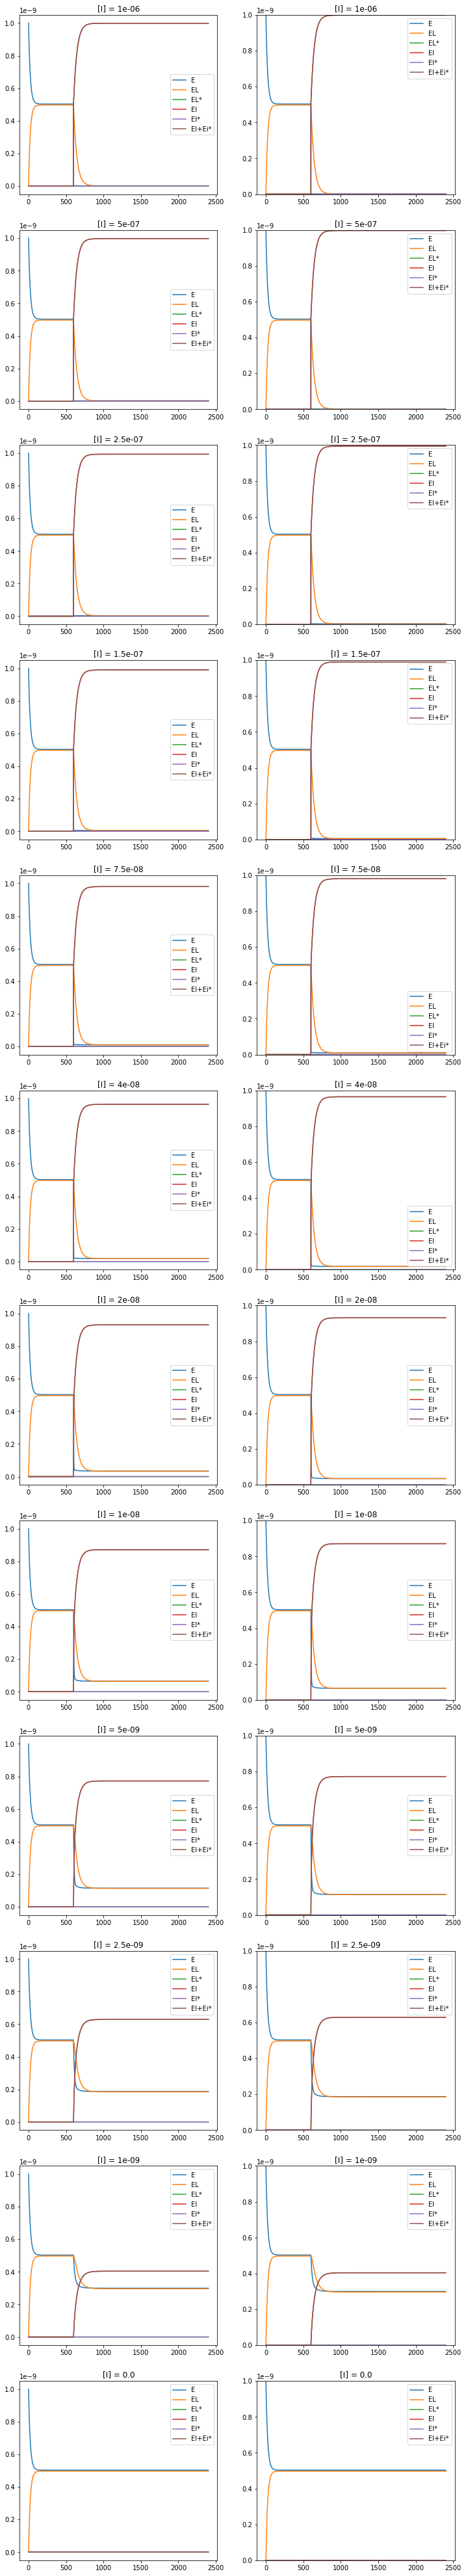

In [25]:
# This will make all the plots and dataframes
dataframes = []
fig, axes = plt.subplots(len(all_plots), 2, figsize=(12,len(all_plots)*6))
for n, plot in enumerate(all_plots):
  # Splits de lijst van figuren in E, EL, EL*, EI en EI*
  Eplot = [] 
  ESplot = []
  Pplot = []
  EIplot = []
  EIiplot = []
  EItot = []
  for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 
    
   # Plot de figuren
  labels = ('E', 'EL', "EL*", "EI", "EI*", "EI+Ei*")
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    axes[n,0].plot(y, label=labels[i])
  axes[n,0].legend()
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
      axes[n,1].plot(y, label=labels[i])
  axes[n,1].legend()
  axes[n,1].set_ylim(0,E0) #zoom in tot E0
  axes[n,0].set_title("[I] = {}".format(str(Is[n])))
  axes[n,1].set_title("[I] = {}".format(str(Is[n])))
  
  df = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "EL":ESplot, "ELi":Pplot})
  dataframes.append(df)
df = pd.concat(dataframes, keys=[I for I in Is], axis=1) # Combine all the dataframes

In [26]:
df

0.000001                     ... 0.000000                   
                 E            EI  EIi  ...      EIi            EL  ELi
0     1.000000e-09  0.000000e+00  0.0  ...      0.0  0.000000e+00  0.0
1     9.782400e-10  0.000000e+00  0.0  ...      0.0  2.175998e-11  0.0
2     9.574324e-10  0.000000e+00  0.0  ...      0.0  4.256764e-11  0.0
3     9.375353e-10  0.000000e+00  0.0  ...      0.0  6.246467e-11  0.0
4     9.185091e-10  0.000000e+00  0.0  ...      0.0  8.149091e-11  0.0
...            ...           ...  ...  ...      ...           ...  ...
2396  7.405345e-13  9.985272e-10  0.0  ...      0.0  4.972067e-10  0.0
2397  7.405345e-13  9.985272e-10  0.0  ...      0.0  4.972067e-10  0.0
2398  7.405345e-13  9.985272e-10  0.0  ...      0.0  4.972067e-10  0.0
2399  7.405345e-13  9.985272e-10  0.0  ...      0.0  4.972067e-10  0.0
2400  7.405345e-13  9.985272e-10  0.0  ...      0.0  4.972067e-10  0.0

[2401 rows x 60 columns]

In [27]:
df.iloc[30]

1.000000e-06  E      6.326557e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     3.673443e-10
              ELi    0.000000e+00
5.000000e-07  E      6.326557e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     3.673443e-10
              ELi    0.000000e+00
2.500000e-07  E      6.326557e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     3.673443e-10
              ELi    0.000000e+00
1.500000e-07  E      6.326557e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     3.673443e-10
              ELi    0.000000e+00
7.500000e-08  E      6.326557e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     3.673443e-10
              ELi    0.000000e+00
4.000000e-08  E      6.326557e-10
              EI     0.000000e+00
              EIi    0.000000e+00
              EL     3.673443e-10
              

In [28]:
print(df.to_csv())

,1e-06,1e-06,1e-06,1e-06,1e-06,5e-07,5e-07,5e-07,5e-07,5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,7.5e-08,7.5e-08,7.5e-08,7.5e-08,7.5e-08,4e-08,4e-08,4e-08,4e-08,4e-08,2e-08,2e-08,2e-08,2e-08,2e-08,1e-08,1e-08,1e-08,1e-08,1e-08,5e-09,5e-09,5e-09,5e-09,5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,1e-09,1e-09,1e-09,1e-09,1e-09,0.0,0.0,0.0,0.0,0.0
,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi,E,EI,EIi,EL,ELi
0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0,1e-09,0.0,0.0,0.0,0.0
1,9.782400238526034e-10,0.0,0.0,2.1759976147395013e-11,0.0,9.782400238526034e-10,0.0,0.0,2.1759976147395013e-11,0.0,9.782400238526034e-10,0.0,0.0,2.17